In [1]:
import json
import os
from pathlib import Path
from PIL import Image, ImageOps
import re
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the SDK
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, view_points

# Here is an outline of the contents of this image preprocessing Notebook. The intention of this Notebook is that it will be ran in advance of the Training_Inference Notebook. No actually training or model development happens here. It is strictly image processing and data organization.

- Set user_path_prefix variable. This variable must be set in order to make all filepaths relative!

- Because Lyft does not provide ground truth lables for their testing data in their Kaggle competition, we are going to treat the Validation data (taken from the training images and bounding boxes) as our testing data to perform inference on. We randomly split our training and validation data by the date they were recorded. This ensures we control for seasonality of the data and at a minimum ensures that we don't have imagery captures from the same route on the same day.

- Split our data into Train and Validation sets. Split on date value. Set split to roughly 80/20.

    - Define Utility functions

        - train_val_split

        - image_category_train_val_split

        - merge_img_bx_lookup

        - crop_to_boundingbox

        - dynamic_transform

        - crop_image_extremities

        - find_unique_img_sizes

        - display_sample_boxes

- Image Classification

    - Take the images from image_box_lookup and perform Image Classification processing on them. This includes:
    - (image_category_train_val_split) Step 1a: This utility function is the most significant preprocessing step as it is what actually goes into the lyft SDK 
        - and creates a data dictionary that connects the file path, bounding box coordinates, camera intrinsic matrix, sample token, and camera token for each individual image making all subsequent processing easier.
    - (crop_to_boundingbox) Step 1b: We only want to worry about classification at this point, so we "cheat" by utilizing the bounding boxes to crop our starting images.
        - This essentially means that we will have j bounding box sized images resulting from every ith image. It is possible that some j images overlap.
    - (dynamic_transform) Step 2: All of our input images into our Classification model must be the same size. Because the bounding boxes varied in size, our inital cropped images will also vary in size.
        - Either pad up or crop down to a preset image size.
    - Now, we have gone from full sized images to multiple, bounding box sized images per original image, and finally to uniformly sized images that are centered on the object.
    - The two steps above are the only two essential preprocessing steps for Image Classification

    - Processing Steps 1a &1b

    - The cell below will write the corresponding "image_box_lookup".json dict to disk, and then it will perform bounding box cropping and write the resulting images to the corresponding subdirectories.

    - Step 2: We further process the cropped images to match a uniform size which the classification model expects. dynamic_transform either pads up or crops down the initially cropped images since the bounding box that defined the cropping extent varies across boxes. We use a size of 224. Note that you can actually create multiple sizes at once by passing in more than one size ot the sizes parameter. This will write the newly resized images to disk with a directory name corresponding to the "\size\category_size"

    - Read in our image_box_lookup JSON tables that were produced in 'image_category_train_val_split'

    - Observe resulting files

    - Observe breakdown of train vs validation image quantities as well as the images that are our positive category "pedestrian".

    - Visualize our bounding boxes converted from their 3D form to 2D form.

- Object Detection

    - The only preprocessing step we currently implement that is unique for Object Detection is to filter out the regions of the original images that we know do not contain our positive class (see the heatmaps at the end of the Notebook). Essentially, this one step is a simple cropping of the top or top and bottom of the original images that correspond to "the sky" and "the "hood/body of the car". Although cropping is a simplistic operation, we must consider two things:
    - A) Not every image is the same size. The images provided consist of sizes:
        - Size: (1224, 1024), Count: 111888
        - Size: (2048, 864), Count: 18648
        - Size: (1920, 1080), Count: 28221
        - In the second case, we only crop the top of the image
    - B) When we crop the image along the y axis, we shift the coordinates. This shift must then also be applied to every corresponding bounding box in the image. If this is not done, you will see bounding boxes floating above or below their intended target location in the image.

    - ATTENTION: crop_image_extremities relies on img_bx_lookup.json, but it will ALTER the coordinates of the boxes. So, it needs it's own version of img_bx_lookukp to operate on. Manually copy the two tables from
        - os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup\train_merged.json"

        to 

        - os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection\img_bx_lookup\train_merged.json"

    These tables will be read in and operated on in the cell below.

- Extremely brief Data Exploration

- Once all of our Image Preprocessing is done, take a minute to do some basic data exploration.

# Set user_path_prefix variable. This variable must be set in order to make all filepaths relative!

In [2]:
user_path_prefix = r"S:\MADS\Capstone"

In [3]:
data_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train")
json_path = os.path.join(user_path_prefix, "3d-object-detection-for-autonomous-vehicles\Train\data")
lyftdata = LyftDataset(data_path=data_path, json_path=json_path, verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 8.3 seconds.
Reverse indexing ...
Done reverse indexing in 2.7 seconds.


## Because Lyft does not provide ground truth lables for their testing data in their Kaggle competition, we are going to treat the Validation data (taken from the training images and bounding boxes) as our testing data to perform inference on. We randomly split our training and validation data by the date they were recorded. This ensures we control for seasonality of the data and at a minimum ensures that we don't have imagery captures from the same route on the same day.

## Split our data into Train and Validation sets. Split on date value. Set split to roughly 80/20.

### Define Utility functions

In [27]:
import nbformat

def print_markdown_cells_as_bullets(notebook_path):
    """
    Prints all markdown cells from a Jupyter Notebook in a bulleted list format.

    Parameters:
    -----------
    notebook_path (str): The file path of the Jupyter Notebook.
    """
    # Load the notebook
    with open(notebook_path, 'r', encoding='utf-8') as nb_file:
        nb_contents = nbformat.read(nb_file, as_version=4)

    # Iterate through all cells in the notebook
    for cell in nb_contents.cells:
        # Check if the cell is a markdown cell
        if cell.cell_type == 'markdown':
            markdown_content = cell.source
            # Remove '#' characters used for markdown headings
            markdown_content = markdown_content.replace('#', '')
            print(f"- {markdown_content.strip()}\n")

# Example usage
notebook_path = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Notebooks\lyft_preprocessing.ipynb'
print_markdown_cells_as_bullets(notebook_path)


- Set user_path_prefix variable. This variable must be set in order to make all filepaths relative!

- Because Lyft does not provide ground truth lables for their testing data in their Kaggle competition, we are going to treat the Validation data (taken from the training images and bounding boxes) as our testing data to perform inference on. We randomly split our training and validation data by the date they were recorded. This ensures we control for seasonality of the data and at a minimum ensures that we don't have imagery captures from the same route on the same day.

- Split our data into Train and Validation sets. Split on date value. Set split to roughly 80/20.

- Define Utility functions

- train_val_split

- image_category_train_val_split

- merge_img_bx_lookup

- crop_to_boundingbox

- dynamic_transform

- crop_image_extremities

- find_unique_img_sizes

- display_sample_boxes

- Image Classification

- Take the images from image_box_lookup and perform Image Classification pro

#### train_val_split

In [5]:
def train_val_split(lyft_logs):
    """
    This function takes a list of logs from the Lyft dataset and splits them into training and validation sets.
    It first extracts unique dates from the logs, sorts them, and then allocates 1 out of every 5 dates to the 
    validation set. This results in approximately 20% of the dates being in the validation set and 80% in the 
    training set. The function returns tokens for logs corresponding to these dates.

    Parameters:
      lyft_logs (list of dicts): A list of dictionaries where each dictionary contains information about a log 
                               entry in the Lyft dataset, including 'date_captured' and 'token' fields.

    Returns:
      dict: A dictionary with two keys 'train_logs_tokens' and 'validation_logs_tokens'. Each key maps to a list 
          of tokens corresponding to log entries in the training and validation sets, respectively.

    Notes: 
      Although only 20% of the dates will pertain to the Validation set, this does not guarantee that the data
      itself will be split in these proportions as the amount of data collected on a given day can vary.
    """
    
    unique_dates = sorted(list({d["date_captured"] for d in lyft_logs}))

    #Put 1 in every 5 dates in validation set. This should result in 1/5th of the dates in validation and 4/5th in train.
    train_dates = sorted([unique_dates[i] for i in range(len(unique_dates)) if i % 5 != 0])
    validation_dates = sorted([unique_dates[i] for i in range(len(unique_dates)) if i % 5 == 0])

    train_logs_tokens = list({d["token"] for d in lyftdata.log if d["date_captured"] in train_dates})
    validation_logs_tokens = list({d["token"] for d in lyftdata.log if d["date_captured"] in validation_dates})

    return {"train_logs_tokens": train_logs_tokens, "validation_logs_tokens": validation_logs_tokens}

#### image_category_train_val_split

In [6]:
#In order to find the image files that contain our pedestrian_anns, we must do the following:
#Accumulate the superset of Samples that contain all of our pedestrian_annotations
def image_category_train_val_split(category_name, lyft_dataset_object, category_enumeration = None, box_size_threshold = 5000, positive_category = None, image_box_lookup = None, box_visibility = BoxVisibility.ALL):
    """
    This function processes images from the Lyft dataset and categorizes them into training and validation sets based on the presence of a specified category. 
    It filters annotations by category name and date captured, extracts bounding box information, and organizes this data for use in Image Classification and Object Detection models.

    Parameters:
        category_name (str): The category name to filter annotations.
        lyft_dataset_object (LyftDataset): An instance of the LyftDataset class.
        category_enumeration (dict, optional): A dictionary mapping category names to enumeration values. Defaults to a predefined category set if None.
        box_size_threshold (int, optional): The minimum area threshold for a bounding box to be considered. Defaults to 5000 image units.
        positive_category (str, optional): The category name to be treated as a positive label in a binary classification setting. Defaults to None.
        image_box_lookup (str, optional): File path to store the image and bounding box data dictionary. Defaults to None.
        box_visibility (BoxVisibility, optional): The level of box visibility in the image required to consider an annotation. Defaults to BoxVisibility.ALL.

    Returns:
        list: A list containing two elements. Each element is a list of tuples, where each tuple consists of the file path, bounding box coordinates, camera intrinsic matrix, sample token, and camera token. 
        The first element of the list corresponds to the training data, and the second to the validation data.

    Notes:
        The function is designed to run iteratively for each category. For multiple categories, it should be called separately for each one. 
        The function also writes the bounding box data to a JSON file if `image_box_lookup` is provided.
    """

    if image_box_lookup:
        img_bx_lookup = {}

    #If no category_enumeration is provided, use the default. Notice: This filters out the 'car' category to avoid class imbalance.
    if category_enumeration is None:
        category_enumeration = {'pedestrian': 1,
        'animal': 2,
        'other_vehicle': 3,
        'bus': 4,
        'motorcycle': 5,
        'truck': 6,
        'emergency_vehicle': 7,
        'bicycle': 8}

    train_val_images_boxes = []
    # Split our images into train and validation sets. 
    # We don't actually write them to different directories, but rather make different dictionary lookups "image_box_lookup" that the model uses to select data for test/validation.
    train_validation_log_tokens = train_val_split(lyft_dataset_object.log)

    for train_val_key, split_data in train_validation_log_tokens.items():

        scenes_tokens = list({d["token"] for d in lyft_dataset_object.scene if d["log_token"] in split_data})
        sample_tokens = list({d["token"] for d in lyft_dataset_object.sample if d["scene_token"] in scenes_tokens})

        
        annotations = lyft_dataset_object.sample_annotation
        #Filter all annotations down to only annotations our our category of interest.
        category_anns = [d for d in annotations if d["category_name"] == category_name]
        #Filter further to only annotations who belong to our set.
        split_anns = [d for d in category_anns if d["sample_token"] in sample_tokens]

        sample_category_tokens = set()
        for ann in split_anns:
            sample_category_tokens.add(ann["sample_token"])

        category_images_boxes = []
        for sample_token in sample_category_tokens:
            sample_record = lyft_dataset_object.get("sample", sample_token)
            sample_anns = sample_record["anns"]
            cams = [key for key in sample_record["data"].keys() if "CAM" in key]
            
            #We unfortunately do have to iterate through each annotation that exists within the sample_record. There typically aren't more than 20-30 or so.
            #This is because we are in search of the corresponding filepath (and image name) and these must be fetched through .get_sample_data() with the ann supplied as an argument.
            for ann in sample_anns:
                # Figure out which camera the object is fully visible in (this may return nothing)
                for cam in cams:
                    path, box, camera_intrinsic = lyft_dataset_object.get_sample_data(sample_record["data"][cam], box_vis_level=box_visibility, selected_anntokens=[ann])
                    if box:
                        if box[0].name == category_name:
                            #Get the 2D coordinates of our bounding box. This applies the 'camera_intrinsic' matrix via 'view_points' which transforms the box coords from global space to image space.
                            box_coords_all = view_points(box[0].corners(), view = camera_intrinsic, normalize=True)[:2, :]
                            # Calculate bounding box coordinates
                            x_min = np.min(box_coords_all[0])
                            y_min = np.min(box_coords_all[1])
                            x_max = np.max(box_coords_all[0])
                            y_max = np.max(box_coords_all[1])
                            box_coords = [x_min, y_min, x_max, y_max]
                            # Calculate the area of the bounding box
                            box_area = (x_max - x_min) * (y_max - y_min)

                            category_images_boxes.append((str(path), box_coords, camera_intrinsic, sample_token, cam, ann))


                            #Only perform this final code block if image_box_lookup path is given
                            # Get our label which we want to add to img_bx_lookup so we can pass box coords and corresponding labels to our object detection model.
                            if image_box_lookup and box_area >= box_size_threshold:                                
                                # For binary model where positive categories == 1 and all other categories == 0. 
                                if positive_category:
                                    #Get the 0 index so our label variable is not nested.
                                    label = [1 if category_name == positive_category else 0][0]
                                # Otherwise, standard category input corresponding to one of the input categories in category_enumeration.
                                else:
                                    #Get the 0 index so our label variable is not nested.
                                    label = category_enumeration[category_name][0]
                                
                                #Get the name of the image file itself from the full path.
                                match = re.search(r'images\\(.+)', str(path))
                                if match:
                                    file_name = match.group(1)
                                if file_name in img_bx_lookup:
                                    # If the file_name already exists in the dictionary
                                    img_bx_lookup[file_name]["boxes"].append(box_coords)
                                    img_bx_lookup[file_name]["labels"].append(label)
                                else:
                                    # If the file_name does not exist in the dictionary, create a new entry
                                    # We are not populating predictions here, but they will be used later in Object Detection.
                                    img_bx_lookup[file_name] = {"boxes": [box_coords], "labels": [label], "predicted_boxes": [], "predicted_labels": []}

        train_val_images_boxes.append(category_images_boxes)
        
        # Write our image_box_lookup dict to disk.
        if image_box_lookup:
            out_path = os.path.join(image_box_lookup, train_val_key + f"_{category_name}.json")
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            # Write to a JSON file
            with open(out_path, 'w') as file:
                json.dump(img_bx_lookup, file)
        
    return train_val_images_boxes
    

#### merge_img_bx_lookup

In [7]:
def merge_img_bx_lookup(base_path, file_prefix, merged_filename):
    """
    This function scans a specified directory for JSON files that start with a given prefix. It then
    merges the contents of these files into a single dictionary and writes this merged dictionary to a new JSON file.

    Parameters:
    -----------
    base_path (str): The path to the directory containing the JSON files to be merged.
    file_prefix (str): The prefix used to identify the relevant JSON files in the directory.
    merged_filename (str): The filename for the merged JSON file to be created.

    Notes:
    ------
    - The function expects each JSON file to contain a dictionary where keys are image names and values 
      are dictionaries with 'boxes', 'labels', 'predicted_boxes', and 'predicted_labels'.
    - The 'predicted_boxes' and 'predicted_labels' in each file are initially empty lists.
    - If a key (image name) exists in multiple files, their corresponding boxes, labels, and (if present)
      predicted data are merged (appended).
    - The merged dictionary is saved as a new JSON file in the same directory with the specified 'merged_filename'.

    Example of JSON file structure:
    {
        "image1.jpg": {
            "boxes": [[x1, y1, x2, y2], ...],
            "labels": [1, 0, ...],
            "predicted_boxes": [],
            "predicted_labels": []
        },
        ...
    }
    """
    merged_dict = {}
    json_files = [f for f in os.listdir(base_path) if f.startswith(file_prefix) and f.endswith('.json')]

    for file_name in json_files:
        full_path = os.path.join(base_path, file_name)
        with open(full_path, "r") as f:
            file_data = json.load(f)

            for key, value in file_data.items():
                if key not in merged_dict:
                    # If the key is not present, add it with its value
                    merged_dict[key] = value
                else:
                    # If the key is present, extend the boxes and labels
                    merged_dict[key]['boxes'].extend(value['boxes'])
                    merged_dict[key]['labels'].extend(value['labels'])
                    merged_dict[key]['predicted_boxes'].extend(value.get('predicted_boxes', []))
                    merged_dict[key]['predicted_labels'].extend(value.get('predicted_labels', []))

    # Write the merged dictionary to a file
    merged_file_path = os.path.join(base_path, merged_filename)
    with open(merged_file_path, "w") as outfile:
        json.dump(merged_dict, outfile, indent=4)


#### crop_to_boundingbox

In [8]:
def crop_to_boundingbox(image_category_train_val_split, output_path, box_area_threshold = 5000):
    """
    Crops an image to its bounding box if the area of the bounding box exceeds a specified threshold.

    This function processes an image based on provided bounding box coordinates. If the area of the 
    bounding box is larger than the specified threshold, it crops the image to this bounding box 
    and saves the cropped image to a specified output path.

    Parameters:
    -----------
    image_category_train_val_split (tuple): A tuple containing information about the image and bounding box.
                                            Structure: (path, box_coords, camera_intrinsic, sample_token, cam, ann)
    output_path (str): The directory path where the cropped images will be saved.
    box_area_threshold (int, optional): The minimum area threshold for the bounding box to perform cropping. 
                                        Default is 5000.

    Example of 'image_category_train_val_split' tuple structure:
    (
        "path/to/image.jpg",               # Image path
        (np.array([...]), np.array([...])), # Bounding box coordinates
        camera_intrinsic_matrix,            # Camera intrinsic matrix (not used in cropping)
        "sample_token",                     # Sample token (identifier) (not used in cropping)
        "cam",                              # Camera identifier (not used in cropping)
        "ann"                               # Annotation token
    )
    """
    path, box_coords, camera_intrinsic, sample_token, cam, ann = image_category_train_val_split
    
    # Calculate bounding box coordinates
    x_min = np.min(box_coords[0])
    y_min = np.min(box_coords[1])
    x_max = np.max(box_coords[0])
    y_max = np.max(box_coords[1])

    # Calculate the area of the bounding box
    box_area = (x_max - x_min) * (y_max - y_min)

    if box_area > box_area_threshold:
        image = Image.open(path)
        match = re.search(r'images\\(.+)', path)

        if match:
            file_name = match.group(1)
        else:
            print("Pattern not found in the path", path)
            pass

        # Crop the image. This is our initial cropping from the full size image. It is with respect to the bounding box size using box_area_threshold.
        # Pillow uses a system of (left, upper, right, lower)
        image_cropped = image.crop((x_min, y_min, x_max, y_max))

        # Check if the directory exists, if not, create it
        Path(output_path).mkdir(parents=True, exist_ok=True)
        #Save the image
        image_cropped.save(os.path.join(output_path, "cropped_" + file_name[:-5] + "_" + ann + file_name[-5:]))

#### dynamic_transform

In [9]:
def dynamic_transform(cropped_images_dir, image_sizes_list, lyftdata):
    """
    This function processes images stored in subdirectories (each named after a category) within the specified 
    'cropped_images_dir'. For each size in 'image_sizes_list', it resizes or crops each image to create a new 
    set of images of the specified size.

    Parameters:
    -----------
    cropped_images_dir (str): The base directory path where the categorized images are stored.
    image_sizes_list (list of int): A list of sizes to which the images need to be transformed.
    lyftdata: An object containing dataset metadata, specifically the categories of interest.

    Notes:
    ------
    - The function iterates over each category defined in 'lyftdata' except for 'car'.
    - For each category, it creates a new output directory named as '<category>_<size>'.
    - Each image in the category is processed to match the target size.
    - Images smaller than the required size are padded with black color to match the target size.
    - Images larger than the required size are center-cropped to the target size.
    - If the final size of any image does not match the target size, a RuntimeError is raised.
    - The transformed images are saved in the respective new output directories with the same filenames as the original images.
    """

    for size in image_sizes_list:
        categories = [d["name"] for d in lyftdata.category if d["name"] != "car"]
        for category in categories:
            category_dir = os.path.join(cropped_images_dir, category)
            new_out_dir = os.path.join(cropped_images_dir, category + "_" + str(size))
                
            if not os.path.exists(new_out_dir):
                os.makedirs(new_out_dir)

            #For each image in the directory "category", modify it such that it is resized to "size".
            for image_file in os.listdir(category_dir):
                image_path = os.path.join(category_dir, image_file)
                image_main = Image.open(image_path)
                images = [image_main]

                for image in images:
                    image_width, image_height = image.size

                    if image_width < size or image_height < size:
                        # Calculate padding
                        padding_left = (size - image_width) // 2 if image_width < size else 0
                        padding_top = (size - image_height) // 2 if image_height < size else 0

                        # Adjust for odd total padding
                        padding_right = size - image_width - padding_left
                        padding_bottom = size - image_height - padding_top

                        # Apply padding
                        image = ImageOps.expand(image, (padding_left, padding_top, padding_right, padding_bottom), fill=0)

                    elif image_width > size or image_height > size:
                        # Crop the image to the required size if it's larger
                        image = transforms.CenterCrop(size)(image)

                    # No else case needed, as no action is taken if the image is already the required size
                    if image.size != (size, size):
                        # Raise an exception
                        raise RuntimeError(f"Image size after transformation does not match required size of {size} for image and instead is of size {image.size}: {image_path}. Original image size: {image_width} {image_height}")
                    
                    # Save the transformed image
                    image.save(os.path.join(new_out_dir, image_file))

#### crop_image_extremities

In [10]:
def crop_image_extremities(image_directory, outdirectory, image_box_lookup_paths, height_range=None, width_range=None):
    """
    Crops images in a specified directory based on height and width ranges and updates the bounding box coordinates.

    This function processes images that are listed in the image_box_lookup tables for training and validation datasets. 
    It crops these images based on the specified height and/or width ranges and saves the cropped images to a specified output directory. 
    Additionally, it updates the bounding box coordinates in the image_box_lookup tables to align with the cropped images.

    Parameters:
    -----------
    image_directory (str): The path to the directory containing the original images.
    outdirectory (str): The path to the directory where cropped images will be saved.
    image_box_lookup_paths (list of str): A list of two paths, where the first path is to the training image_box_lookup 
                                          and the second is to the validation image_box_lookup.
    height_range (tuple of int, optional): A tuple specifying the vertical range (start, end) for cropping. Default is None.
    width_range (tuple of int, optional): A tuple specifying the horizontal range (start, end) for cropping. Default is None.

    Notes:
    ------
    - The function identifies images for processing based on the entries in the provided image_box_lookup tables.
    - Only the images present in these lookup tables are processed, which helps in focusing only on relevant images.
    - The function handles different cropping strategies based on the size of the images.
    - Cropping top-only is applied to images of known size (2048x864), while a more general cropping is applied to other sizes.
    - The bounding box coordinates in the lookup tables are adjusted to reflect the cropped images.
    - The function provides progress updates during processing.
    """
    
    with open(image_box_lookup_paths[0]) as f:
        image_box_lookup_training = json.load(f)
    with open(image_box_lookup_paths[1]) as f:
        image_box_lookup_validation = json.load(f)
    
    #We create images_subset so we only spend time cropping images that we know have objects in them and have been recorded in our image_box_lookup tables.
    images_subset = set(list(image_box_lookup_training.keys()) + list(image_box_lookup_validation.keys()))
    known_sizes = [(2048, 864), (1224, 1024), (1920, 1080)]

    # all_image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]

    total_images = len(images_subset)
    processed_images = 0

    #Instead of performing croping for all 150k images, we only crop the images we know we will be feeding into the model as indicated by our image_subset.
    #Otherwise, we may waste time processing images that arent in our respective image_box_lookup tables. 
    for filename in images_subset:
        filepath = os.path.join(image_directory, filename)
        with Image.open(filepath) as img:
            width, height = img.size
            
            # We only crop the top of these images
            if img.size == known_sizes[0]:
                crop_height_top_only = height_range[0]  # Adjust this value as needed
                img_cropped = img.crop((0, crop_height_top_only, width, height))
                out_path = os.path.join(outdirectory, filename)
                img_cropped.save(out_path)

                # If this is an image that corresponds to our given image_box_lookup, this means we have this image and its original bounding box coords as a refernce for model input.
                # When we crop an image, the new location for 0 in the respective axis changes. Thus, if we don't perform the same change in our bounding box coords, they will shift and be incorrect.
                if filename in image_box_lookup_training.keys() or filename in image_box_lookup_validation.keys():
                    boxes = image_box_lookup_training.get(filename, {}).get("boxes", []) or \
                            image_box_lookup_validation.get(filename, {}).get("boxes", [])
                    updated_boxes = []
                    for box_coords in boxes:
                        x1, y1, x2, y2 = box_coords
                        y1_new = max(y1-height_range[0], 0)
                        y2_new = max(y2-height_range[0], 0)
                        updated_boxes.append([x1, y1_new, x2, y2_new])
                    # Update the box coordinates in the lookup
                    if filename in image_box_lookup_training:
                        image_box_lookup_training[filename]["boxes"] = updated_boxes
                    elif filename in image_box_lookup_validation:
                        image_box_lookup_validation[filename]["boxes"] = updated_boxes


            # Crop both the top and bottom of these images
            else:
                left = width_range[0] if width_range else 0
                upper = height_range[0] if height_range else 0
                right = width_range[1] if width_range else width
                lower = height_range[1] if height_range else height

                img_cropped = img.crop((left, upper, right, lower))
                out_path = os.path.join(outdirectory, filename)
                img_cropped.save(out_path)

                # If this is an image that corresponds to our given image_box_lookup, this means we have this image and its original bounding box coords as a refernce for model input.
                # When we crop an image, the new location for 0 in the respective axis changes. Thus, if we don't perform the same change in our bounding box coords, they will shift and be incorrect.
                if filename in image_box_lookup_training.keys() or filename in image_box_lookup_validation.keys():
                    boxes = image_box_lookup_training.get(filename, {}).get("boxes", []) or \
                            image_box_lookup_validation.get(filename, {}).get("boxes", [])
                    updated_boxes = []
                    for box_coords in boxes:
                        x1, y1, x2, y2 = box_coords
                        y1_new = max(y1 - height_range[0], 0)
                        y2_new = min(y2 - height_range[0], height_range[1] - height_range[0])
                        updated_boxes.append([x1, y1_new, x2, y2_new])
                    # Update the box coordinates in the lookup
                    if filename in image_box_lookup_training:
                        image_box_lookup_training[filename]["boxes"] = updated_boxes
                    elif filename in image_box_lookup_validation:
                        image_box_lookup_validation[filename]["boxes"] = updated_boxes

        #Print progress at 10% intervals.
        processed_images += 1
        if processed_images % (total_images // 10) == 0 or processed_images == total_images:
            print(f"Processed {processed_images / total_images * 100:.0f}% of images")

        with open(os.path.join(outdirectory, "img_bx_lookup", "train_merged.json"), "w") as f:
            json.dump(image_box_lookup_training, f)
        with open(os.path.join(outdirectory, "img_bx_lookup", "validation_merged.json"), "w") as f:
            json.dump(image_box_lookup_training, f)

    print("Processing complete.")


#### find_unique_img_sizes

In [11]:
def find_unique_img_sizes(img_dir):
    """
    This function scans a directory for image files and catalogs each distinct image size it encounters, 
    maintaining a record of the filenames and the number of occurrences of each size.

    Parameters:
    -----------
    img_dir (str): The directory path where image files are stored.

    Returns:
    --------
    dict: A dictionary where each key is a tuple representing a unique image size (width, height), and the value is 
          another dictionary with two keys: 'images', a list of filenames of that size, and 'count', the number of 
          images of that size.
    """
        
    unique_sizes = {}
    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    
    for filename in image_files:
        filepath = os.path.join(img_dir, filename)
        with Image.open(filepath) as img:
            width, height = img.size
            size_tuple = (width, height)

            if size_tuple not in unique_sizes:
                unique_sizes[size_tuple] = {"images": [], "count": 0}

            unique_sizes[size_tuple]["images"].append(filename)
            unique_sizes[size_tuple]["count"] += 1

    return unique_sizes

#### display_sample_boxes

In [12]:
def display_sample_boxes(main_images_path, data_dict_single):
    """
    This function takes a single image's data, including ground truth and predicted bounding boxes, and visually 
    displays these boxes on the image. Ground truth boxes are displayed in blue or red based on their label, and 
    predicted boxes are displayed in green.

    Parameters:
    -----------
    main_images_path (str): The directory path where the main image files are stored.
    data_dict_single (dict): A dictionary containing bounding box data for a single image. The dictionary should 
                             include keys 'boxes' and 'labels' for ground truth, and 'predicted_boxes' and 
                             'predicted_labels' for predictions.

    The function uses matplotlib to create a plot where the image is displayed and bounding boxes are overlaid.
    Ground truth boxes are colored based on their label (blue for label 1, red for other labels), while 
    predicted boxes are always green. 
    """

    image_name = list(data_dict_single.keys())[0]
    image_path = os.path.join(main_images_path, image_name)
    image = Image.open(image_path)
    gt_boxes = data_dict_single[image_name]["boxes"]
    gt_labels = data_dict_single[image_name]["labels"]
    predicted_boxes = data_dict_single[image_name]["predicted_boxes"]
    predicted_labels = data_dict_single[image_name]["predicted_labels"]

    # Create a matplotlib figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch for the bounding box
    for i in range(len(gt_boxes)):
        x_min = gt_boxes[i][0]
        y_min = gt_boxes[i][1]
        x_max = gt_boxes[i][2]
        y_max = gt_boxes[i][3]
        label = gt_labels[i]
        color = ["b" if label == 1 else "r"][0]

        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor=color, facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)

    for i in range(len(predicted_boxes)):
        x_min = predicted_boxes[i][0]
        y_min = predicted_boxes[i][1]
        x_max = predicted_boxes[i][2]
        y_max = predicted_boxes[i][3]
        # label = predicted_labels[i]
        # color = ["b" if label == 1 else "r"][0]

        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor="g", facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)

    # Display the plot
    plt.show()

# Image Classification

## Take the images from image_box_lookup and perform Image Classification processing on them. This includes:
- (image_category_train_val_split) Step 1a: This utility function is the most significant preprocessing step as it is what actually goes into the lyft SDK 
    - and creates a data dictionary that connects the file path, bounding box coordinates, camera intrinsic matrix, sample token, and camera token for each individual image making all subsequent processing easier.
- (crop_to_boundingbox) Step 1b: We only want to worry about classification at this point, so we "cheat" by utilizing the bounding boxes to crop our starting images.
    - This essentially means that we will have j bounding box sized images resulting from every ith image. It is possible that some j images overlap.
- (dynamic_transform) Step 2: All of our input images into our Classification model must be the same size. Because the bounding boxes varied in size, our inital cropped images will also vary in size.
    - Either pad up or crop down to a preset image size.
- Now, we have gone from full sized images to multiple, bounding box sized images per original image, and finally to uniformly sized images that are centered on the object.
- The two steps above are the only two essential preprocessing steps for Image Classification

## Processing Steps 1a &1b

### The cell below will write the corresponding "image_box_lookup".json dict to disk, and then it will perform bounding box cropping and write the resulting images to the corresponding subdirectories.

In [7]:
train_logs_tokens, validation_logs_tokens = train_val_split(lyftdata.log)
image_box_lookup_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup")
categories = [lyftdata.category[i]["name"] for i in range(len(lyftdata.category))]
for cat in categories:

    #We can skip car because we have chosen to not include it for reasons regarding it's large size which increases preprocessing time and creates more of a class imbalance. 
    if cat != "car":
        #Obtain all of the annotations and their corresponding data via image_class_selector
        cat_train_val_images_boxes = image_category_train_val_split(cat, lyftdata, train_validation_log_tokens= [train_logs_tokens, validation_logs_tokens], image_box_lookup=image_box_lookup_path)

        cat_train = cat_train_val_images_boxes[0]
        cat_val = cat_train_val_images_boxes[1]

        #Do the actual cropping and write cropped images to disk
        train_image_output_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\train_cropped_images", cat +"_cropped")
        val_image_output_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\validation_cropped_images", cat +"_cropped")
        
        for i in range(len(cat_train)):
            crop_to_boundingbox(cat_train[i], output_path=train_image_output_path, box_area_threshold=5000)

        for i in range(len(cat_val)):
            crop_to_boundingbox(cat_val[i], output_path=val_image_output_path, box_area_threshold=5000)

### Step 2: We further process the cropped images to match a uniform size which the classification model expects. dynamic_transform either pads up or crops down the initially cropped images since the bounding box that defined the cropping extent varies across boxes. We use a size of 224. Note that you can actually create multiple sizes at once by passing in more than one size ot the sizes parameter. This will write the newly resized images to disk with a directory name corresponding to the "\size\category_size"

In [25]:
cropped_images_dir = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\Image_Classification\train_cropped_images")
sizes = [224]
dynamic_transform(cropped_images_dir, sizes, lyftdata, partial_images=False)

## Read in our image_box_lookup JSON tables that were produced in 'image_category_train_val_split'

In [13]:
image_box_lookup_base_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup")
image_box_lookup_files = os.listdir(image_box_lookup_base_path)
merge_img_bx_lookup(image_box_lookup_base_path, "train", "train_merged.json")
merge_img_bx_lookup(image_box_lookup_base_path, "validation", "validation_merged.json")

In [14]:
train_merged_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup\train_merged.json")
train_pedestrians_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup\train_logs_tokens_pedestrian.json")
validation_merged_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup\validation_merged.json")
validation_pedestrians_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup\validation_logs_tokens_pedestrian.json")

#### Observe resulting files

In [18]:
#Print out the resulting files for reference.
img_bx_reference = {}
for f in image_box_lookup_files:
    file_path = os.path.join(image_box_lookup_base_path, f)
    with open(file_path, "r") as file:
        d = json.load(file)
        img_bx_reference[f] = d
        
img_bx_reference.keys()


dict_keys(['train_logs_tokens_animal.json', 'train_logs_tokens_bicycle.json', 'train_logs_tokens_bus.json', 'train_logs_tokens_emergency_vehicle.json', 'train_logs_tokens_motorcycle.json', 'train_logs_tokens_other_vehicle.json', 'train_logs_tokens_pedestrian.json', 'train_logs_tokens_truck.json', 'train_merged.json', 'train_merged_backup.json', 'validation_logs_tokens_animal.json', 'validation_logs_tokens_bicycle.json', 'validation_logs_tokens_bus.json', 'validation_logs_tokens_emergency_vehicle.json', 'validation_logs_tokens_motorcycle.json', 'validation_logs_tokens_other_vehicle.json', 'validation_logs_tokens_pedestrian.json', 'validation_logs_tokens_truck.json', 'validation_merged.json', 'validation_merged_backup.json'])

#### Observe breakdown of train vs validation image quantities as well as the images that are our positive category "pedestrian".

In [19]:
train_merged = img_bx_reference["train_merged.json"]
validation_merged = img_bx_reference["validation_merged.json"]
print("Num train images: ", len(train_merged))
print("Num validation images: ",len(validation_merged))

validation_positive_images = []
for k, v in validation_merged.items():
    labels = v["labels"]
    if any(labels):
        validation_positive_images.append(k)

print("Num validation positive category images: ",len(validation_positive_images))

train_positive_images = []
for k, v in train_merged.items():
    labels = v["labels"]
    if any(labels):
        train_positive_images.append(k)

print("Num train positive category images: ",len(train_positive_images))

Num train images:  28600
Num validation images:  35226
Num validation positive category images:  6219
Num train positive category images:  5367


In [23]:
#View contents
train_merged['host-a004_cam0_1232817652451064006.jpeg']

{'boxes': [[963.2922978186496,
   676.5313843966901,
   1136.0242514354854,
   776.4546413663261],
  [722.7988805255987, 496.614778432843, 849.0012625293366, 604.402950528869],
  [777.6164623794784, 515.205862285076, 859.8336773765589, 664.184520253418],
  [963.2922978186496,
   676.5313843966901,
   1136.0242514354854,
   776.4546413663261],
  [722.7988805255987, 496.614778432843, 849.0012625293366, 604.402950528869],
  [777.6164623794784, 515.205862285076, 859.8336773765589, 664.184520253418],
  [963.2922978186496,
   676.5313843966901,
   1136.0242514354854,
   776.4546413663261],
  [722.7988805255987, 496.614778432843, 849.0012625293366, 604.402950528869],
  [777.6164623794784, 515.205862285076, 859.8336773765589, 664.184520253418],
  [963.2922978186496,
   676.5313843966901,
   1136.0242514354854,
   776.4546413663261],
  [722.7988805255987, 496.614778432843, 849.0012625293366, 604.402950528869],
  [777.6164623794784, 515.205862285076, 859.8336773765589, 664.184520253418]],
 'labe

#### Visualize our bounding boxes converted from their 3D form to 2D form.

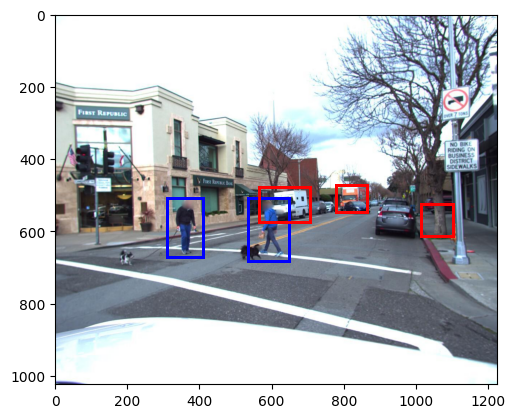

In [22]:
main_images_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images")
test_image = 'host-a011_cam1_1233087927034517006.jpeg'
data_dict_single = {k:v for k,v in train_merged.items() if k == test_image}
display_sample_boxes(main_images_path=main_images_path, data_dict_single=data_dict_single)

# Object Detection

## The only preprocessing step we currently implement that is unique for Object Detection is to filter out the regions of the original images that we know do not contain our positive class (see the heatmaps at the end of the Notebook). Essentially, this one step is a simple cropping of the top or top and bottom of the original images that correspond to "the sky" and "the "hood/body of the car". Although cropping is a simplistic operation, we must consider two things:
- A) Not every image is the same size. The images provided consist of sizes:
    - Size: (1224, 1024), Count: 111888
    - Size: (2048, 864), Count: 18648
    - Size: (1920, 1080), Count: 28221
    - In the second case, we only crop the top of the image
- B) When we crop the image along the y axis, we shift the coordinates. This shift must then also be applied to every corresponding bounding box in the image. If this is not done, you will see bounding boxes floating above or below their intended target location in the image.

In [71]:
main_images_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images")
image_size_unique = find_unique_img_sizes(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images")

for size, data in image_size_unique.items():
    # print(f"Size: {size}, Count: {data['count']}, Images: {data['images']}")
    print(f"Size: {size}, Count: {data['count']}")


Size: (1224, 1024), Count: 111888
Size: (2048, 864), Count: 18648
Size: (1920, 1080), Count: 28221


## ATTENTION: crop_image_extremities relies on img_bx_lookup.json, but it will ALTER the coordinates of the boxes. So, it needs it's own version of img_bx_lookukp to operate on. Manually copy the two tables from
- os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup\train_merged.json"

to 

- os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection\img_bx_lookup\train_merged.json"

## These tables will be read in and operated on in the cell below.

In [ ]:
out_directory_path = main_images_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection")
image_box_lookup_paths =[os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection\img_bx_lookup\train_merged.json"),
                         os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection\img_bx_lookup\validation_merged.json")]
crop_image_extremities(main_images_path, outdirectory=out_directory_path, image_box_lookup_paths=image_box_lookup_paths, height_range=(300, 1100), width_range=None)

# Extremely brief Data Exploration

## Once all of our Image Preprocessing is done, take a minute to do some basic data exploration. 

### Category distribution

In [5]:
annos_class = lyftdata.sample_annotation
categories = [d["name"] for d in lyftdata.category if d["name"] != "car"]
#Filter all annotations down to only annotations our our class of interest.
# class_anns = [d for d in annos_class if d["category_name"] == class_name]
categories

['pedestrian',
 'animal',
 'other_vehicle',
 'bus',
 'motorcycle',
 'truck',
 'emergency_vehicle',
 'bicycle']

In [6]:
#Create category countes to visualize their distribution
category_distribution = {}
for cat in categories:
    category_distribution[cat] = 0

for d in lyftdata.sample_annotation:
    if d["category_name"] != "car":
        category_distribution[d["category_name"]] +=1

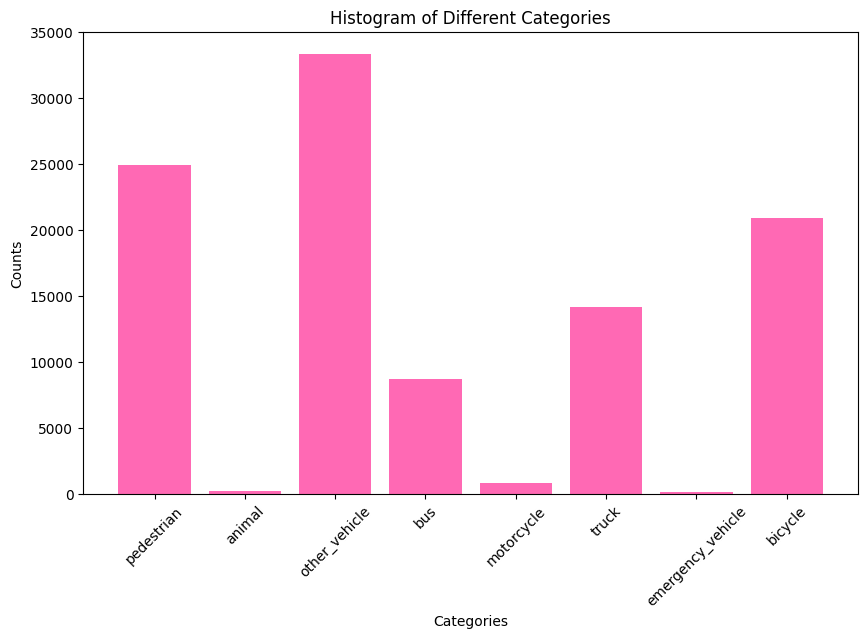

In [12]:
# Extracting keys and values
categories = list(category_distribution.keys())
counts = list(category_distribution.values())

# Creating the histogram
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='hotpink')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Histogram of Different Categories')
plt.xticks(rotation=45)  # Rotate category labels for better readability

# Show the plot
plt.savefig(r"S:\MADS\Capstone\Report_examples\category_distribution", bbox_inches='tight')
plt.show()

### Lastly, it is helpful to visualize why we cropped the images for object detection by their top and bottom quarters. The heatmaps below depict where all positive class (i.e. Pedestrians) are located in image space for all data over the Train and Validation sets. The first heatmap is a standard heat map and the second heat map displays a binary mask where the purple area is the extent of all pedestrian bounding boxes. At least for our case, we can decrease the image size input by removing the regions of the image we are 100% sure our category of interest does not exist in (this may not be true for hypothetical test data, so proceed with caution)

In [13]:
train_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\train_logs_tokens_pedestrian.json")
val_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\validation_logs_tokens_pedestrian.json")
with open(train_path, 'r') as file:
    train_pedestrians = json.load(file)
with open(val_path, 'r') as file:
    val_pedestrians = json.load(file)

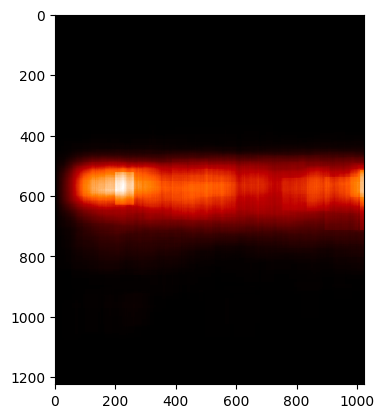

In [19]:
#Code below generated with ChatGPT 4
# Initialize heatmap grid
heatmap = np.zeros((1224, 1024))

def update_heatmap(pedestrians):
    for filename, coords in pedestrians.items():
        box_coords = coords["boxes"][0]

        # Calculate bounding box coordinates and round to nearest integer
        x_min, y_min, x_max, y_max = map(int, map(np.round, box_coords))

        # Adjust if the coordinates are outside the image
        x_min = max(x_min, 0)
        y_min = max(y_min, 0)
        x_max = min(x_max, heatmap.shape[1] - 1)
        y_max = min(y_max, heatmap.shape[0] - 1)

        # Update heatmap
        heatmap[y_min:y_max, x_min:x_max] += 1

# Update heatmap with train and validation data
update_heatmap(train_pedestrians)
update_heatmap(val_pedestrians)

# Check if the heatmap is entirely zeros
if np.max(heatmap) == 0:
    print("Heatmap is empty. Check bounding box coordinates.")
else:
    # Normalize the heatmap
    heatmap = heatmap / np.max(heatmap)

    # Plot the heatmap
    plt.imshow(heatmap, cmap='gist_heat', interpolation='nearest')
    plt.show()

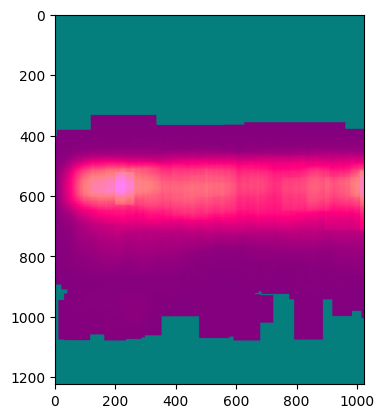

In [20]:
# Create a mask for any non-zero values
outlier_mask = heatmap > 0

# Plot the heatmap with non-zero values highlighted
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.imshow(outlier_mask, cmap='cool', alpha=0.5) # overlaying with a different color
plt.show()

# Move to training_inference Notebook with completion of preprocessing